# Devoir Python

Vous devez rendre votre devoir sur GitHub.
Vous avez le droit a tout vos documents et a internet

1. votre depot doit etre privé
2. vous devez inviter comme colaborateur votre chargé de TD/TP
3. Seul le dernier commit avant la fin de la séance sera corrigé.


Ex 1: Integrale de Romberg

Ecrire une fonction integ_romberg(f, a, b, epsilon=1e-6) permettant de calculer l’intégrale numérique de la fonction f entre les bornes a et b avec une précision epsilon selon la méthode de Romberg (https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Romberg).

Il s’agit d’une méthode qui permet d’améliorer les méthodes usuelles de calcul numérique des intégrales, comme la méthode des Trapèzes.
On montre qu’en combinant judicieusement les valeurs obtenues par la méthode des Trapèzes pour différentes subdivisons de l’intervalle d’intégration, on augmente l’ordre de convergence (sa vitesse de convergence). 


In [ ]:
def f(x):
    return x ** 5


def integ_romberg(f, a, b, eps=10 ** -6):
    R = []
    hn = (b - a)
    R.append([(hn / 2.0) * (f(a) + f(b))])
    for i in range(1, eps + 1):
        hn = hn / 2
        total = 0
        for j in range(1, 2 ** i, 2):
            total += total + f(a + j * hn)

        row_i = [0.5 * R[i - 1][0] + total * hn]

        for k in range(1, i + 1):
            rij = row_i[k - 1] + (row_i[k - 1] - R[i - 1][k - 1]) / (4 ** k - 1)
            row_i.append(rij)

        R.append(row_i)
    return R


Ex 2: Équation d’état de l’eau à partir de la dynamique moléculaire

Afin de modéliser les planètes de type Jupiter, Saturne, ou même des exo-planètes très massives (dites « super-Jupiters »), la connaissance de l’équation d’état des composants est nécessaire. Ces équations d’état doivent être valables jusqu’à plusieurs centaines de méga-bar ; autrement dit, celles-ci ne sont en aucun cas accessibles expérimentalement. On peut cependant obtenir une équation d’état numériquement à partir d’une dynamique moléculaire.

Le principe est le suivant : on place dans une boite un certain nombre de particules régies par les équations microscopiques (Newton par exemple, ou même par des équations prenant en considération la mécanique quantique) puis on laisse celles-ci évoluer dans la boite ; on calcule à chaque pas de temps l’énergie interne à partir des intéractions électrostatiques et la pression à partir du tenseur des contraintes. On obtient en sortie l’évolution du système pour une densité fixée (par le choix de taille de la boite) et une température fixée (par un algorithme de thermostat que nous ne détaillerons pas ici).

On se propose d’analyser quelques fichiers de sortie de tels calculs pour l’équation d’état de l’eau à très haute pression. Les fichiers de sortie sont disponibles ici; leur nom indique les conditions thermodynamiques correspondant au fichier, p.ex. 6000K_30gcc.out pour T=6000
K et ρ=30 gcc. Le but est, pour chaque condition température-densité, d’extraire l’évolution de l’énergie et de la pression au cours du temps, puis d’en extraire la valeur moyenne ainsi que les fluctuations. Il arrive souvent que l’état initial choisi pour le système ne corresponde pas à son état d’équilibre, et qu’il faille donc « jeter » les quelques pas de temps en début de simulation qui correspondent à cette relaxation du système. Pour savoir combien de temps prend cette relaxation, il sera utile de tracer l’évolution au cours du temps de la pression et l’énergie pour quelques simulations. Une fois l’équation d’état P(ρ,T) et E(ρ,T) extraite, on pourra tracer le réseau d’isothermes.

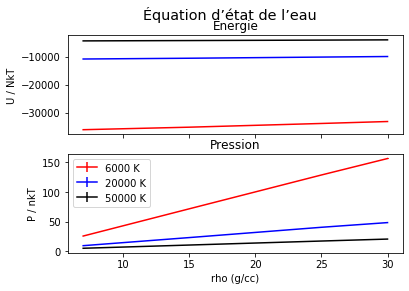

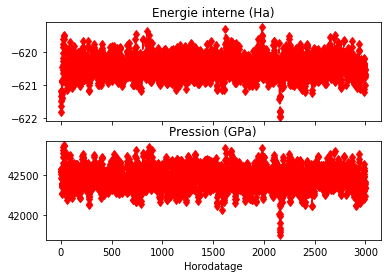

In [10]:
import numpy as N
import matplotlib.pyplot as P

class Simulation:

    def __init__(self, temp, dens, path):

        self.temp = float(temp)
        self.dens = float(dens)
        tmp = N.loadtxt(path, skiprows=1).T
        self.pot = tmp[0]
        self.kin = tmp[1]
        self.tot = self.pot + self.kin
        self.press = tmp[2]

    def thermo(self, skipSteps=0):
        
        return {'T': self.temp,
                'rho': self.dens,
                'E': self.tot[skipSteps:].mean(),
                'P': self.press[skipSteps:].mean(),
                'dE': self.tot[skipSteps:].std(),
                'dP': self.press[skipSteps:].std()}

    def plot(self, skipSteps=0):
       
        fig, (axen, axpress) = P.subplots(2, sharex=True)
        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:],
                  'rd--')
        axen.set_title("Energie interne (Ha)")
        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:],
                     'rd--')
        axpress.set_title("Pression (GPa)")
        axpress.set_xlabel("Horodatage")

        P.show()
if __name__ == '__main__':
    a0 = 0.52918      
    amu = 1.6605      
    k_B = 3.16681e-6
    nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu
    nsteps = 200
    temps = [6000, 20000, 50000]
    colors = {6000: 'r', 20000: 'b', 50000: 'k'}
    denss = [7, 15, 25, 30]
    keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']
    eos = dict.fromkeys(keys, N.zeros(0))

    for t, rho in [(t, rho) for t in temps for rho in denss]:
        filenm = "outputs/{}K_{:0>2d}gcc.out".format(t, rho)
        s = Simulation(t, rho, filenm)
        for key in keys:
            eos[key] = N.append(eos[key], s.thermo(nsteps)[key])

    fig, (axen, axpress) = P.subplots(2, sharex=True)
    fig.suptitle("Équation d’état de l’eau", size='x-large')
    axen.set_title("Energie")
    axen.set_ylabel("U / NkT")
    axpress.set_title("Pression")
    axpress.set_ylabel("P / nkT")
    axpress.set_xlabel("rho (g/cc)")
    for t in temps:
        sel = eos['T'] == t
        axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,
                      yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')
        axpress.errorbar(x=eos['rho'][sel],
                         y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,
                         yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,
                         fmt=colors[t] + '-',
                         label="{} K".format(t))
    axpress.legend(loc='best')
    P.show()
    s.plot()

Ex 3: Le problème du voyageur de commerce

Le problème du voyageur de commerce est un problème d’optimisation consistant à déterminer le plus court chemin reliant un ensemble de destinations. Il n’existe pas d’algorithme donnant la solution optimale en un temps raisonnable (problème NP-complet), mais l’on peut chercher à déterminer des solutions approchées. On va se placer ici dans le cas d’un livreur devant desservir une seule fois chacune des n destinations d’une ville américaine où les rues sont agencées en réseau carré. 

On utilise la « distance de Manhattan »  entre deux points 𝐴(𝑥𝐴,𝑦𝐴) et 𝐵(𝑥𝐵,𝑦𝐵) : 𝑑(𝐴,𝐵) =|𝑥𝐵−𝑥𝐴|+|𝑦𝐵−𝑦𝐴|.

En outre, on se place dans le cas où les coordonnées des destinations sont entières, comprises entre 0 (inclus) et TAILLE = 50 (exclus). Deux destinations peuvent éventuellement avoir les mêmes coordonnées. Les instructions suivantes doivent permettre de définir les classes nécessaires (Ville et Trajet) et de développer un algorithme approché (heuristiques) : l’algorithme du plus proche voisin. 

Seules la librairie standard et la librairie numpy sont utilisables si nécessaire. Implementer les classes et methodes suivante:


Classe Ville:
* __init__(): initialisation d’une ville sans destination.
* aleatoire(n): création de n destinations aléatoires.
* nb_trajet(): retourne le nombre total (entier) de trajets :(𝑛−1)!/2(utilisermath.factorial()).
* distance(i, j): retourne la distance (Manhattan) entre les deux destinations de numéro i et j


Classe Trajet:
* __init__(ville, etapes=None): initialisation sur une ville. Si la liste etapes n’est pas spécifiée, le trajet par défaut est celui suivant les destinations de ville.
* longueur(): retourne la longueur totale du trajetbouclé(i.e. revenant à son point de départ).


Plus proche voisin:
* Ville.plus_proche(i, exclus=[]): retourne la destination la plus proche de la destinationi(au sens de Ville.distance()), hors les destinations de la liste exclus
* Ville.trajet_voisins(depart=0): retourne un Trajet déterminé selon l’heuristique des plus proches voisins (i.e. l’étape suivante est la destination la plus proche hors les destinations déjà visitées) en partant de l’étape initiale depart

Optimisation:
* Proposer un algorithme qui propose une meilleur alternative au "plus proche voisin".

Interface:
* Ville.figure(trajet=None): Afficher le plan de la ville et le trajet obtenue (utiliser matplotlib.step()pour des trajets de type « Manhattan »)

In [ ]:
import math
import numpy as np

np.random.seed(123)
TAILLE = 50


class Ville(object):

    def __init__(self):

        self.destinations = np.array([]).reshape(-1, 2)

    def aleatoire(self, n=20):

        self.destinations = np.random.randint(TAILLE, size=(n, 2))

    def nb_trajets(self):

        ndest = len(self.destinations)
        if ndest > 2:
            return int(math.factorial(ndest - 1) / 2)
        elif ndest > 0:
            return 1
        else:
            return 0

    def distance(self, i, j):

        return np.abs(self.destinations[i] - self.destinations[j]).sum()

    def plus_proche(self, i, exclus=[]):

        voisins = [j for j in range(len(self.destinations))
                   if j != i and j not in exclus]
        distances = [self.distance(i, j) for j in voisins]

        return voisins[np.argmin(distances)]

    def trajet_voisins(self, depart=0):

        ndest = len(self.destinations)
        if depart is None:  # Boucle sur tous les départs possibles
            trajets = [self.trajet_voisins(depart=i) for i in range(ndest)]
            longueurs = [t.longueur() for t in trajets]

            return trajets[np.argmin(longueurs)]
        else:  # Départ imposé
            etapes = [depart]
            while len(etapes) < ndest:
                i = etapes[-1]
                j = self.plus_proche(i, exclus=etapes[:-1])
                etapes.append(j)

            return Trajet(self, etapes)

    def optimisation_trajet(self, trajet):

        ndest = len(self.destinations)
        trajets = [trajet.interversion(i, j)
                   for i in range(ndest) for j in range(i + 1, ndest)]
        longueurs = [t.longueur() for t in trajets]
        opt = trajets[np.argmin(longueurs)]
        if opt.longueur() > trajet.longueur():
            opt = trajet

        return opt


class Trajet:
    def __init__(self, ville, etapes=None):
        self.ville = ville
        if etapes is None:  # Trajet par défaut
            self.etapes = np.arange(len(self.ville.destinations))
        else:
            self.etapes = np.array(etapes)

    def longueur(self):

        l = sum(self.ville.distance(self.etapes[i], self.etapes[i + 1])
                for i in range(len(self.etapes) - 1))
        l += self.ville.distance(self.etapes[-1], self.etapes[0])

        return l

